# Model Architecture

In [60]:
import datetime, collections

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

## CNN Network

In [2]:
data_path = '../data/deep-learning-with-python-data/tiny-images/'

In [3]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
connected_model = nn.Sequential(
    nn.Linear(3072, 1024), # Linear model is basically equivalent to Keras' Dense layer without activation function applied
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2)
)

In [7]:
# Showing parameters for fully connected (dense) model for images
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [8]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [9]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [10]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [11]:
# The convolution linear operation
conv = nn.Conv2d(3, 16, kernel_size=3) # 3 x 3 x 3 -> 16 x 3 x 3, kernel size: 3 x 3
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [12]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [13]:
# Apply the convolution operation to one image in dataset - notice pixel loss
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

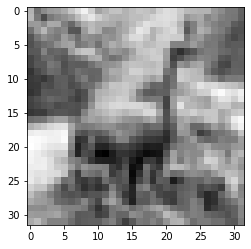

In [14]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

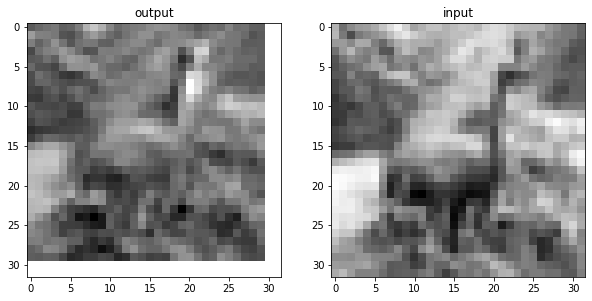

In [15]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

In [16]:
# Applying padding so there is no data loss !important - keep kernel size as odd dimensions
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # <1>
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [17]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

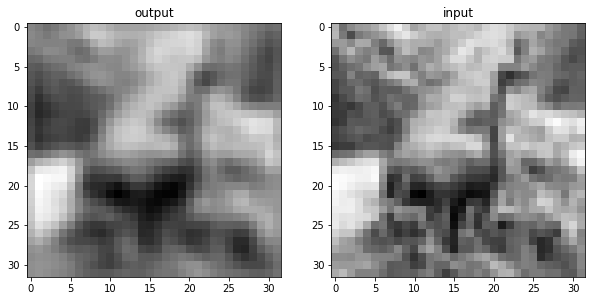

In [18]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F4_PyTorch.png')  # bookskip
plt.show()

In [19]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

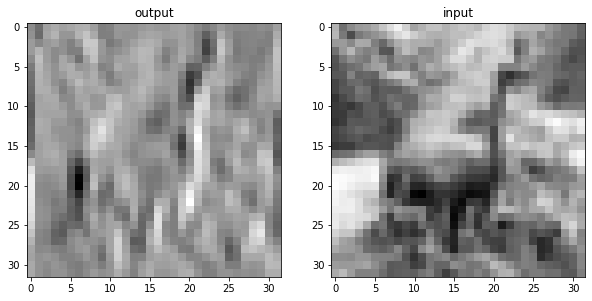

In [20]:
# edge detection
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

In [21]:
# The maxpool layer - takes the maximum value from overlapping samples in order to downsample image - basically allows 
# features to be learned across entire image instead of small segments
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [22]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1), # Upsample
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1), # Downsample
    nn.Tanh(), # We need to convert to fully connected for output
    nn.Linear(8 * 8 * 8, 32), # Need a way to flatten so the dimensions match, could use nn.Flatten
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [23]:
# Creating our own custom layer/module/net - backward does not need to be defined because of autograd
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2) # Best practice to use new instances for each element
    
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # nn.Flatten to appropriate size for dense layers
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [24]:
# Double checking model
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [25]:
# Using functional API for activation functions.  Functional API can be used when parameters aren't being passed in
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [26]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0569,  0.2053]], grad_fn=<AddmmBackward0>)

In [27]:
def training_loop(epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, epochs + 1): # Loop over epochs
        loss_train = 0.0
        for imgs, labels in train_loader: # Loop over batches
            outputs = model(imgs) # Feed forward batch through model
            loss = loss_fn(outputs, labels) # Calculate loss
            optimizer.zero_grad() # Zero gradients from last iteration
            loss.backward() # Calculate gradients
            optimizer.step() # Update parameters in model
            loss_train += loss.item() # Sum loss for epoch
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train / len(train_loader) # Gets average loss per batch
            ))

In [28]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True) # Load our data into batches

model = Net() # Create network
optimizer = optim.SGD(model.parameters(), lr=1e-2) # Create optimizer to update model
loss_fn = nn.CrossEntropyLoss() # Define our loss function (cross-entropy is good for classification problems)

training_loop(
    epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2022-01-24 12:27:00.561230 Epoch 1, Training loss 0.5972959087912444
2022-01-24 12:27:30.121597 Epoch 10, Training loss 0.33226043830631646
2022-01-24 12:28:03.264990 Epoch 20, Training loss 0.29554129804775214
2022-01-24 12:28:36.188836 Epoch 30, Training loss 0.2712473334495429
2022-01-24 12:29:09.212258 Epoch 40, Training loss 0.250808171880473
2022-01-24 12:29:42.267231 Epoch 50, Training loss 0.23589748571253127
2022-01-24 12:30:15.013022 Epoch 60, Training loss 0.22245553719579794
2022-01-24 12:30:47.999567 Epoch 70, Training loss 0.20439702016153152
2022-01-24 12:31:20.565368 Epoch 80, Training loss 0.19139467369598948
2022-01-24 12:31:52.552259 Epoch 90, Training loss 0.17871216046297625
2022-01-24 12:32:25.075211 Epoch 100, Training loss 0.16499143753461776


In [29]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad(): # Not using graidents since we are not training
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # Gives index of highest predicted class value
                total += labels.shape[0] # Count number of samples
                correct += int((predicted == labels).sum()) # Compares truth with predicted value, then sums
        
        print('Accuracy {}: {:.2f}'.format(name, correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.92
Accuracy val: 0.88


In [38]:
# Saving and loading
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [31]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

In [32]:
# Switch to GPU if available
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [33]:
def training_loop(epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train / len(train_loader) # Gets average loss per batch
            ))

In [34]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device) # Move model onto GPU as well
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2022-01-24 12:32:32.241052 Epoch 1, Training loss 0.5798328139220074
2022-01-24 12:32:35.979138 Epoch 10, Training loss 0.32587209600172223
2022-01-24 12:32:40.095314 Epoch 20, Training loss 0.29566413012279824
2022-01-24 12:32:44.207578 Epoch 30, Training loss 0.2722273521647332
2022-01-24 12:32:48.340275 Epoch 40, Training loss 0.24940261273247422
2022-01-24 12:32:52.497710 Epoch 50, Training loss 0.23167222619626174
2022-01-24 12:32:56.592689 Epoch 60, Training loss 0.21480730883065302
2022-01-24 12:33:00.667940 Epoch 70, Training loss 0.19958705659125262
2022-01-24 12:33:04.822346 Epoch 80, Training loss 0.18257037194291498
2022-01-24 12:33:08.961550 Epoch 90, Training loss 0.1678265509711709
2022-01-24 12:33:13.100359 Epoch 100, Training loss 0.1529964344089578


In [35]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        
        print('Accuracy {}: {:.2f}'.format(name, correct / total))
        accdict[name] = correct / total
    return accdict
all_acc_dict['baseline'] = validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.90


In [40]:
# Saving and loading with GPU
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt', map_location=device))

<All keys matched successfully>

## Adding Width

In [41]:
# Increasing width allows model to handle more types of data and potentitally allows it to generalize better
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # Doubled size for extra width
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [42]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2022-01-24 12:35:23.153652 Epoch 1, Training loss 0.5502763437997004
2022-01-24 12:35:27.080881 Epoch 10, Training loss 0.3159978597596952
2022-01-24 12:35:31.455624 Epoch 20, Training loss 0.2796140118579196
2022-01-24 12:35:35.820452 Epoch 30, Training loss 0.24969535221339792
2022-01-24 12:35:40.133538 Epoch 40, Training loss 0.2233839736432786
2022-01-24 12:35:44.503981 Epoch 50, Training loss 0.2001041974041872
2022-01-24 12:35:48.840461 Epoch 60, Training loss 0.17797022426773787
2022-01-24 12:35:53.193283 Epoch 70, Training loss 0.15580934838979107
2022-01-24 12:35:57.542295 Epoch 80, Training loss 0.13442612610235335
2022-01-24 12:36:01.853492 Epoch 90, Training loss 0.11417760061705189
2022-01-24 12:36:06.217672 Epoch 100, Training loss 0.09538572713447983
Accuracy train: 0.96
Accuracy val: 0.90


{'train': 0.9601, 'val': 0.896}

In [43]:
# Parameterizing inputs
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [44]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2022-01-24 12:36:06.932402 Epoch 1, Training loss 0.5618820526417653
2022-01-24 12:36:10.853837 Epoch 10, Training loss 0.325271745301356
2022-01-24 12:36:15.201900 Epoch 20, Training loss 0.2802074126377227
2022-01-24 12:36:19.584570 Epoch 30, Training loss 0.2451161181755886
2022-01-24 12:36:23.948677 Epoch 40, Training loss 0.21541011096185939
2022-01-24 12:36:28.272064 Epoch 50, Training loss 0.18760136476937372
2022-01-24 12:36:32.566950 Epoch 60, Training loss 0.16088437277135575
2022-01-24 12:36:36.859820 Epoch 70, Training loss 0.13603257912264508
2022-01-24 12:36:41.132962 Epoch 80, Training loss 0.11338574496234298
2022-01-24 12:36:45.423922 Epoch 90, Training loss 0.09322047752037549
2022-01-24 12:36:49.701619 Epoch 100, Training loss 0.07580780338756977
Accuracy train: 0.97
Accuracy val: 0.89


In [45]:
sum(p.numel() for p in model.parameters())

38386

## L2 Normalization

L2 Normalization is a strategy for regularization - helping the model generalize, aka decreasing overfitting.  L2 penalizes large weight values.  It is also refered to as "weight decay".  It is done as part of the optimization, or updating the parameters with their new weights based on the calculated gradient

In [46]:
def training_loop_l2reg(epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters()) # Here is the l2 normalization
            
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train / len(train_loader)
            ))

In [47]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2022-01-24 12:36:50.493627 Epoch 1, Training loss 0.6388150626307081
2022-01-24 12:36:55.190133 Epoch 10, Training loss 0.3635518126616812
2022-01-24 12:37:00.478720 Epoch 20, Training loss 0.32806884454693763
2022-01-24 12:37:05.801522 Epoch 30, Training loss 0.3052607043913216
2022-01-24 12:37:11.121371 Epoch 40, Training loss 0.28431696999984185
2022-01-24 12:37:16.418272 Epoch 50, Training loss 0.26594885500373355
2022-01-24 12:37:21.709861 Epoch 60, Training loss 0.25062382325624966
2022-01-24 12:37:27.006526 Epoch 70, Training loss 0.23756182317141514
2022-01-24 12:37:32.311286 Epoch 80, Training loss 0.2260494242143479
2022-01-24 12:37:37.558245 Epoch 90, Training loss 0.2159792453430261
2022-01-24 12:37:42.828850 Epoch 100, Training loss 0.20667099886259455
Accuracy train: 0.92
Accuracy val: 0.88


## Dropout

Dropout is another strategy for reducing overfitting, and is done as a layer in the model.  It 0s out a random part of the output of a network.  It is only available while the model is set to train

In [48]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32): # Using wide architecture again
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4) # Dropout layer 1
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout(p=0.4) # Dropout layer 2
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out) # Passing output through dropout layer 1
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out) # Passing output through dropout layer 2
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [49]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2) # Could put weight decay here for l2 normalization
loss_fn = nn.CrossEntropyLoss()

training_loop(
    epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2022-01-24 12:37:43.612865 Epoch 1, Training loss 0.5701197809094836
2022-01-24 12:37:47.781841 Epoch 10, Training loss 0.36880083875671316
2022-01-24 12:37:52.369204 Epoch 20, Training loss 0.3402285381297397
2022-01-24 12:37:56.900921 Epoch 30, Training loss 0.32295223880725304
2022-01-24 12:38:01.449154 Epoch 40, Training loss 0.3101735209963124
2022-01-24 12:38:06.013865 Epoch 50, Training loss 0.29757820316560707
2022-01-24 12:38:10.541574 Epoch 60, Training loss 0.28560919936295526
2022-01-24 12:38:15.083058 Epoch 70, Training loss 0.2710636852273516
2022-01-24 12:38:19.630661 Epoch 80, Training loss 0.26019519671892666
2022-01-24 12:38:24.236006 Epoch 90, Training loss 0.2485870450830004
2022-01-24 12:38:28.829148 Epoch 100, Training loss 0.2383072279915688
Accuracy train: 0.90
Accuracy val: 0.88


## Batch Normalization

Batch normalization is another strategy to combat overfitting and can be used to either replace or minimize the need of Dropout layers.  Normalization rescales inputs to reach a desired distribution.  It is used as a layer in the model. Used to aid with convergence

In [50]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [51]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2022-01-24 12:38:29.641014 Epoch 1, Training loss 0.4605563226019501
2022-01-24 12:38:34.228282 Epoch 10, Training loss 0.27583825170614157
2022-01-24 12:38:39.294719 Epoch 20, Training loss 0.2131328352602424
2022-01-24 12:38:44.329382 Epoch 30, Training loss 0.16589045296808716
2022-01-24 12:38:49.354504 Epoch 40, Training loss 0.1230609657325942
2022-01-24 12:38:54.381814 Epoch 50, Training loss 0.08492352054187446
2022-01-24 12:38:59.399631 Epoch 60, Training loss 0.05535486883893134
2022-01-24 12:39:04.427026 Epoch 70, Training loss 0.03544614637851905
2022-01-24 12:39:09.506517 Epoch 80, Training loss 0.02251920284655918
2022-01-24 12:39:14.535240 Epoch 90, Training loss 0.019271267388182082
2022-01-24 12:39:19.548659 Epoch 100, Training loss 0.010398797975603943
Accuracy train: 0.99
Accuracy val: 0.87


## Depth

Depth allows models to pick up on different features at different levels of abstraction - eg. found a face, found eyes, found iris.  It is done by adding additional layers to the network.  More layers risk having the gradient vanish - or when the first few layers become useless to the model.  Ways to combat include using skip connections - where certain output layers are fed in as input to another layer several layers down

In [52]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32): # Wider network
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1) # Adding extra layers makes network deeper
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [53]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2022-01-24 12:39:20.387625 Epoch 1, Training loss 0.6810830129179984
2022-01-24 12:39:25.050459 Epoch 10, Training loss 0.3525122217122157
2022-01-24 12:39:30.181369 Epoch 20, Training loss 0.3107954345311329
2022-01-24 12:39:35.296207 Epoch 30, Training loss 0.2774776912229076
2022-01-24 12:39:40.436016 Epoch 40, Training loss 0.24271772555105245
2022-01-24 12:39:45.588709 Epoch 50, Training loss 0.2119709221515686
2022-01-24 12:39:50.749813 Epoch 60, Training loss 0.18584763348861866
2022-01-24 12:39:55.914362 Epoch 70, Training loss 0.1613040807520508
2022-01-24 12:40:01.038898 Epoch 80, Training loss 0.1374874234816451
2022-01-24 12:40:06.162183 Epoch 90, Training loss 0.11403830458593976
2022-01-24 12:40:11.311038 Epoch 100, Training loss 0.09402824348657374
Accuracy train: 0.94
Accuracy val: 0.89


In [54]:
# Skip connections
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2) # skip connection
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [55]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2022-01-24 12:40:12.120380 Epoch 1, Training loss 0.6444216545220394
2022-01-24 12:40:16.856091 Epoch 10, Training loss 0.32824454717575363
2022-01-24 12:40:22.054958 Epoch 20, Training loss 0.28066179763739274
2022-01-24 12:40:27.253467 Epoch 30, Training loss 0.24663594977301398
2022-01-24 12:40:32.425972 Epoch 40, Training loss 0.216209864920112
2022-01-24 12:40:37.617786 Epoch 50, Training loss 0.18802752118011948
2022-01-24 12:40:42.797986 Epoch 60, Training loss 0.16159274438574056
2022-01-24 12:40:48.012272 Epoch 70, Training loss 0.13473675378663524
2022-01-24 12:40:53.206748 Epoch 80, Training loss 0.11008653281980259
2022-01-24 12:40:58.388871 Epoch 90, Training loss 0.0880020090918632
2022-01-24 12:41:03.544274 Epoch 100, Training loss 0.0668767855508597
Accuracy train: 0.97
Accuracy val: 0.90


In [56]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super().__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False) # Batch norm cancels bias so it is left out
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu') # Using a different/custom initialization strategy
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x # skip connection

In [57]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)])
        )
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [58]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2022-01-24 12:41:15.569235 Epoch 1, Training loss 2.0241173300773476
2022-01-24 12:43:01.028196 Epoch 10, Training loss 0.31354483539701267
2022-01-24 12:44:58.110220 Epoch 20, Training loss 0.24543755506254306
2022-01-24 12:46:54.662544 Epoch 30, Training loss 0.19302395047845355
2022-01-24 12:48:51.254660 Epoch 40, Training loss 0.1548568887315738
2022-01-24 12:50:47.680573 Epoch 50, Training loss 0.13414531542806868
2022-01-24 12:52:44.173094 Epoch 60, Training loss 0.1078529726524072
2022-01-24 12:54:40.667000 Epoch 70, Training loss 0.0782019747065226
2022-01-24 12:56:37.213078 Epoch 80, Training loss 0.0964042506014608
2022-01-24 12:58:33.769045 Epoch 90, Training loss 0.053236086144717115
2022-01-24 13:00:30.275572 Epoch 100, Training loss 0.07898775958545079
Accuracy train: 0.97
Accuracy val: 0.86


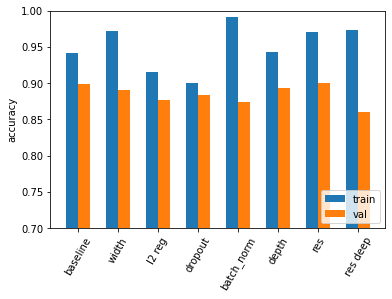

In [61]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()

In [63]:
# Saving and loading
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')